\tableofcontents

# Introduzione

## Ambiente di Sviluppo

Nel nostro caso abbiamo deciso di utilizzare come ambiente di sviluppo i Github Codespaces offerti dall'Università, utilizzando delle impostazioni di configurazione manuale per impostare R, linguaggio di programmazione utilizzato durante il corso, e Jupyter, un ambiente di sviluppo interattivo con il quale è stata scritta questa relazione.\
Per ottenere un ambiente di sviluppo identico al nostro basta creare una repository di Github, inserire la cartella .devcontainer al suo interno e poi creare un codespace sulla repository scelta.

## La nostra Rete

La [rete da noi scelta](http://vlado.fmf.uni-lj.si/pub/networks/data/esna/metalWT.htm) descrive il commercio di oggetti in metallo tra 80 paesi nel mondo nel 1994. \
Un collegamento $Y_{ij}$ rappresenta  la richiesta di oggetti in metallo da parte del nodo $i$ al nodo $j$. 

### Proprietà della Rete

La nostra rete contiene 80 nodi (paesi) e 1000 collegamenti (scambi commerciali) e ogni nodo contiene i seguenti attributi:

- Il loro Continente di appartenenza
- La loro Posizione rispetto alla Struttura del Sistema Mondiale nel 1994
- Il loro PIL diviso per il numero di cittadini all'interno di tale paese nel 1995

Il commercio mondiale di manufatti metallici vari nel 1994 presenta una rete complessa di importazioni. Questi dati, che includono importazioni di prodotti ad alta tecnologia o di manifattura pesante, offrono una finestra unica per esaminare le dinamiche economiche globali. In particolare, si può indagare se esista una correlazione tra la ricchezza di un paese, misurata dal Prodotto Interno Lordo (PIL) pro capite in dollari USA nel 1995, e il suo volume di scambi nella rete. I paesi sono classificati secondo la loro posizione nel sistema mondiale nel 1994, offrendo una prospettiva storica sul loro sviluppo economico e la loro integrazione nel commercio mondiale. Inoltre, la posizione di un paese nel sistema mondiale potrebbe influenzare significativamente il suo volume di scambi: in particolare l’appartenenza continentale dei paesi potrebbe rivelare modelli regionali di commercio e ricchezza. Quindi l’analisi dei dati potrebbe mostrare se i paesi di un particolare continente tendono ad avere volumi di scambio più elevati in relazione alla loro ricchezza. Questo potrebbe indicare come la ricchezza influenzi la domanda di prodotti tecnologicamente avanzati.

---

Dal sito è possibile scaricare soltanto il file 'world_trade.paj' che contiene i nomi delle nazioni, la edge list corrispondente alla nostra rete e gli attributi nodali.
Da questo file abbiamo ricavato il file 'edge_list.txt', contenente la lista degli archi della nostra rete, e 'nodes_attr.txt' contenente i nomi e i relativi attributi nodali dei nodi.
Dopodiché tramite l'utilizzo della libreria igraph abbiamo impostato la nostra rete in R:

In [ ]:
# Rimozione dati dalla sessione di R in caso fossero presenti e carico il workspace
rm(list = ls())
load("workspace.Rdata")

# Creo la funzione che gestira la creazione di immagini a partire da tabelle
createImageFromTable <- function(table, filename, width, height, res){
	png(filename, width = width, height = height, res = res)
    grid.table(table, rows = NULL)
    invisible(dev.off())
}

# Carico le librerie necessarie
library(igraph)
library(ergm)
library(intergraph)
library(sbm)
library(ggplot2)
library(grid)
library(gridExtra)

In [2]:
# Importazione della edge list 
edgeList <- read.table("edge_list.txt", sep = "", head = FALSE)

# Importazione degli attributi dei nodi
attr <- read.table("nodes_attr.txt", sep = "", head = TRUE)

# Creazione del grafo e assegnazione degli attributi ai nodi
g <- graph_from_edgelist(as.matrix(edgeList), directed = TRUE)
V(g)$continent <- attr$Continents
V(g)$gdp <- attr$GDP
V(g)$world_partition <- attr$World_Partitions
V(g)$name <- attr$Names

print(g)

IGRAPH d333001 DN-- 80 1000 -- 
+ attr: continent (v/n), gdp (v/n), world_partition (v/n), name (v/c)
+ edges from d333001 (vertex names):
 [1] United States ->French Guiana France        ->French Guiana
 [3] Germany       ->French Guiana Italy         ->French Guiana
 [5] United States ->Guadeloupe    Belgium/Lux.  ->Guadeloupe   
 [7] France        ->Guadeloupe    Germany       ->Guadeloupe   
 [9] Italy         ->Guadeloupe    United States ->Norway       
[11] Japan         ->Norway        China         ->Norway       
[13] Belgium/Lux.  ->Norway        Denmark       ->Norway       
[15] France        ->Norway        Germany       ->Norway       
+ ... omitted several edges


![](images/MapChart_Map.png)

Questa è una rappresentazione dei nostri 80 paesi divisi in base all'attributo "Continent" secondo i nostri dati.

# Statistiche di Rete

Dopodichè tramite l'utilizzo dei seguenti comandi abbiamo calcolato le nostre statistiche di Rete.

In [3]:
# Creazione della matrice di adiacenza relativa al grafo g
Y <- as_adjacency_matrix(g)
diag(Y) <- NA

# Calcolo delle statistiche di rete
rho <- edge_density(g)
reciprocity <- reciprocity(g)
transitivity <- transitivity(g)
odd_rho <- rho / (1 - rho)
odd_transitivity <- transitivity / (1 - transitivity)
tau <- odd_transitivity / odd_rho
assortativity_continent <- assortativity(g, V(g)$continent, directed = TRUE)
assortativity_gdp <- assortativity(g, V(g)$gdp, directed = TRUE)
assortativity_worldpartition <- assortativity(g, V(g)$world_partition, directed = TRUE)

# Create a table with names and values
table <- data.frame(
	Name = c("Edge Density", "Reciprocity", "Transitivity", "Tau", "Assortativity (Continent)", "Assortativity (GDP)", "Assortativity (World Partition)"),
	Value = c(rho, reciprocity, transitivity, tau, assortativity_continent, assortativity_gdp, assortativity_worldpartition)
)

createImageFromTable(table, filename = "images/NetworkStatisticsTable.png", width = 1500, height = 1050, res = 440)

![](images/NetworkStatisticsTable.png)

Tabella delle Statistiche di Rete

Dall'immagine sopra possiamo estrapolare delle informazioni riguardo alla nostra rete, cioè:

- Circa 1/4 delle connessioni è reciprocata.
- La transitività nella nostra rete è molto alta, circa 4 volte di più rispetto al caso random.
- Il coefficiente di assortatività è positivo per tutti e 3 gli attributi nodali.

Con queste informazioni possiamo già dire che la nostra rete ha un'alta tendenza a formare dei cluster (o gruppi).

# Statistiche Nodali

Per quanto riguarda le Statistiche Nodali, cioè:

- Degree Centrality
- Closeness Centrality
- Betweenness Centrality
- Eigen-Vector Centrality

abbiamo ottenuto i seguenti risultati:

## Degree Centrality

Nel nostro caso la Degree Centrality può essere interpretata come un valore che indica se un paese effettua dei commerci relativi agli oggetti in metallo oppure no.

Essendo la nostra rete una rete direzionata, dobbiamo osservare sia la In-Degree Centrality che la Out-Degree Centrality.

In [4]:
in_degree <- degree(g, mode = "in")
out_degree <- degree(g, mode = "out")

### In-Degree Centrality

I dati da noi ottenuti per la In-Degree Centrality sono i seguenti:

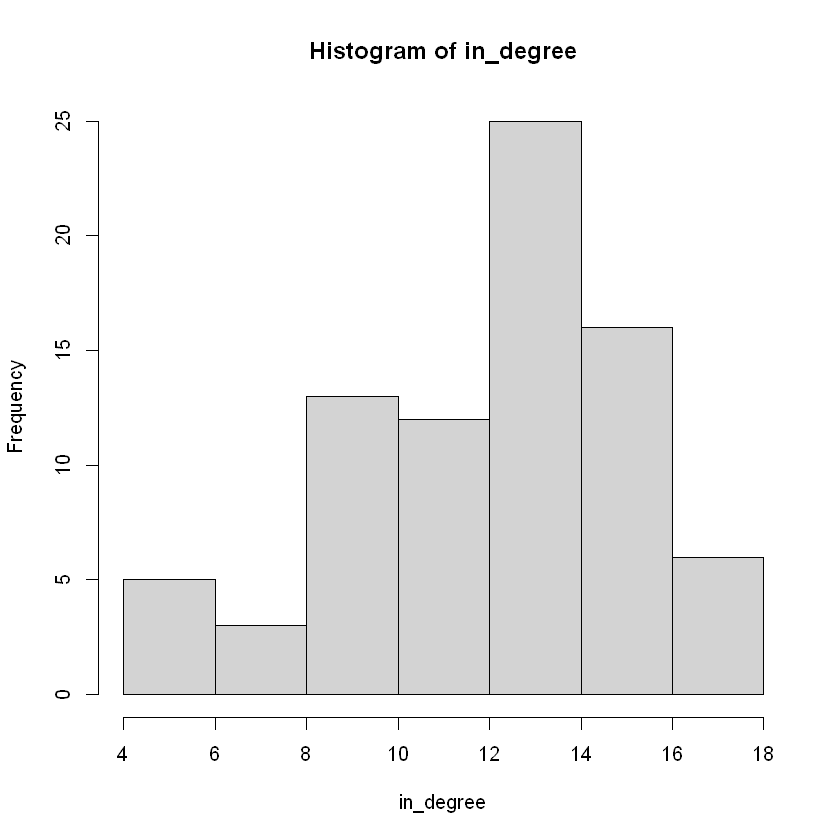

In [5]:
# Istogramma dell'In Degree Centrality
hist(in_degree)

In [6]:
# Stampo il Summary dell'In Degree Centrality
summary(in_degree)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    4.0    10.0    13.0    12.5    15.0    18.0 

![](imagesWorldMaps/In_Degree_Centrality.png)

Top 10 Nazioni rispetto all'In Degree

In [7]:
# Stampo la centralità della Rete rispetto all'In Degree
centr_degree(g, loops = FALSE, mode = "in")$centralization

[1] 0.07050152

#### Conclusioni

Come possiamo vedere dall'istogramma e dal valore di centralizzazione, tutti i paesi esportano metalli, e non ci sono paesi che esportano in maniera molto più marcata rispetto ad altri

### Out-Degree Centrality

Invece per quanto riguarda la Out-Degree Centrality abbiamo ottenuto i seguenti risultati:

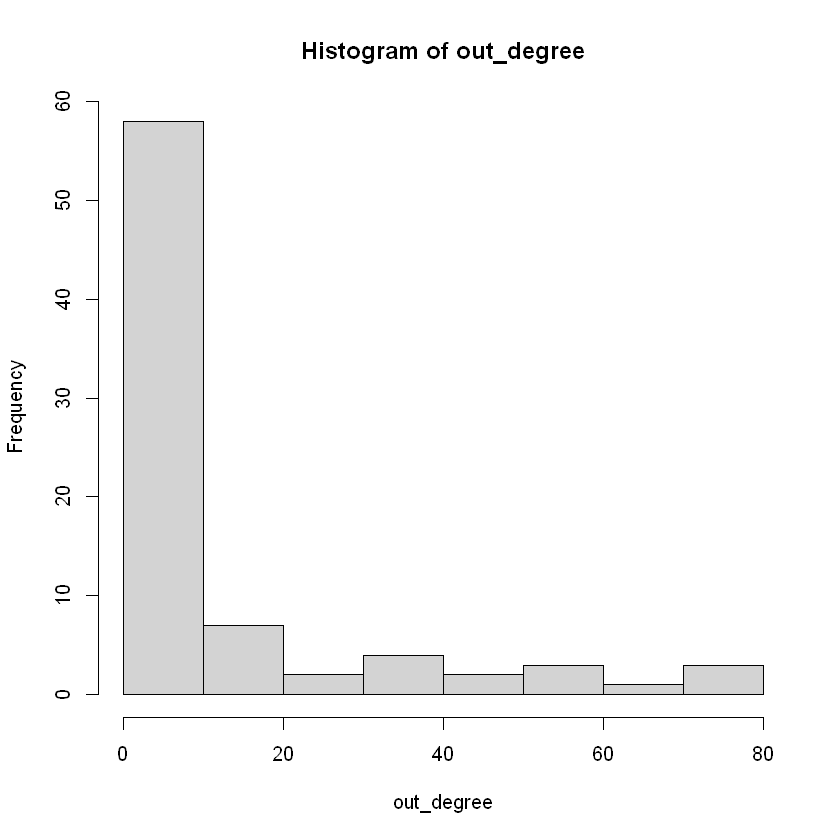

In [8]:
# Istogramma dell'In Degree Centrality
hist(out_degree, breaks = 10)

In [9]:
# Stampo il Summary dell'In Degree Centrality
summary(out_degree)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     4.0    12.5    13.0    77.0 

![](imagesWorldMaps/Out_Degree_Centrality.png)

Top 10 Nazioni rispetto all'Out Degree

In [10]:
# Stampo la centralità della Rete rispetto all'In Degree
centr_degree(g, loops = FALSE, mode = "out")$centralization

[1] 0.8267906

#### Conclusioni

Stavolta, visualizzando l'istogramma e il valore di centralizzazione possiamo vedere come ci siano alcuni nodi che sono molto più centrali di altri. Dal grafico riportato sopra possiamo concludere che questi sono i paesi più sviluppati (Stati Uniti, paesi europei e Cina)

## Closeness Centrality

Nel nostro caso non siamo riusciti a trovare un 'senso' alla Closeness Centrality, abbiamo comunque deciso di studiarla perchè forse potrebbe risultare qualche informazione interessante.

Essendo la nostra rete una rete direzionata, dobbiamo osservare sia la In-Closeness Centrality che la Out-Closeness Centrality.

In [11]:
closeness_in <- closeness(g, mode = "in")
closeness_out <- closeness(g, mode = "out")

### In-Closeness Centrality

I Dati da noi ottenuti per la In-Closeness Centrality sono i seguenti

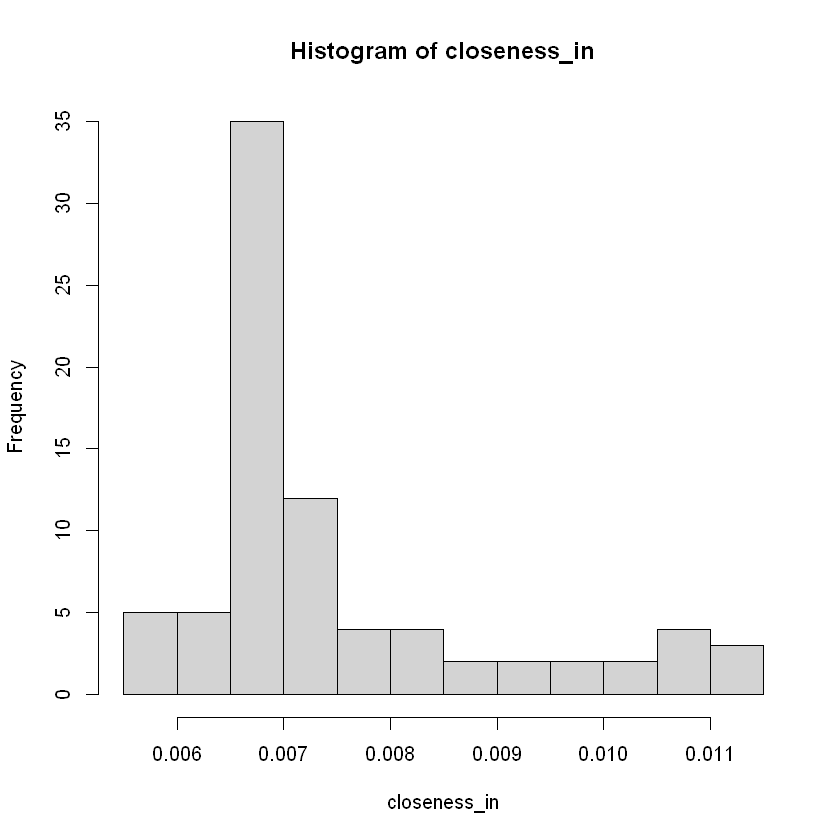

In [12]:
#Istogramma dell'In-Closeness Centrality
hist(closeness_in)

In [13]:
summary(closeness_in)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.005848 0.006623 0.006944 0.007488 0.007634 0.011364 

![](imagesWorldMaps/In_Closeness_Centrality.png)

Top 10 Nazioni rispetto all'In Closeness

In [14]:
centr_clo(g, mode = "in")$centralization

[1] 0.1766785

#### Conclusioni

- Nella rete non sono presenti nodi con In Closeness infinita, il che implica che tutti i nodi sono raggiungibili da ogni altro nodo
- I Paesi con l'In Closeness maggiore sono quasi tutti Paesi dell'America del Sud (questa informazione potrebbe essere interessante da studiare, ma non essendo oggetto della nostra relazione non abbiamo approfondito oltre)

### Out-Closeness Centrality

I Dati da noi ottenuti per la In-Closeness Centrality sono i seguenti

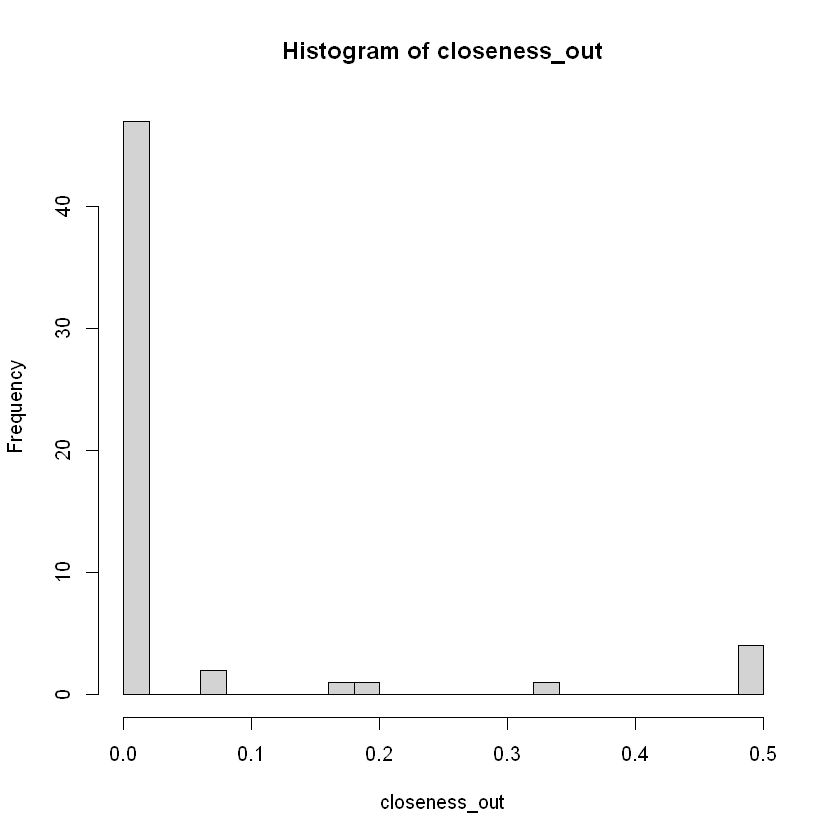

In [15]:
#Istogramma dell'Out-Closeness Centrality
hist(closeness_out, breaks = 20)

In [16]:
summary(closeness_out)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
0.001435 0.004959 0.006645 0.056027 0.009901 0.500000       24 

![](imagesWorldMaps/Out_Closeness_Centrality.png)

Top 10 Nazioni rispetto all'Out Closeness

In [17]:
centr_clo(g, mode = "out")$centralization

[1] NaN

#### Conclusioni

- Nella Rete sono presenti nodi con Out Closeness pari a infinito, questo è dato dal fatto che esistono nodi che non inviano collegamenti (come abbiamo visto nell'Out Degree)
- La maggior parte dei nodi presenta un Out Closeness < 0.1
- Il valore di centralizzazione non è disponibile dato che esistono valori per il quale l'Out Closeness è infinito

## Betweenness Centrality

Nel nostro caso potremmo interpretare la Betweenness Centrality come una misura di quanto uno specifico nodo faccia da tramite per il commercio fra i paesi

In [18]:
betweenness <- betweenness(g, directed = TRUE)

I dati da noi ottenuti per la Betweenness Centrality sono i seguenti:

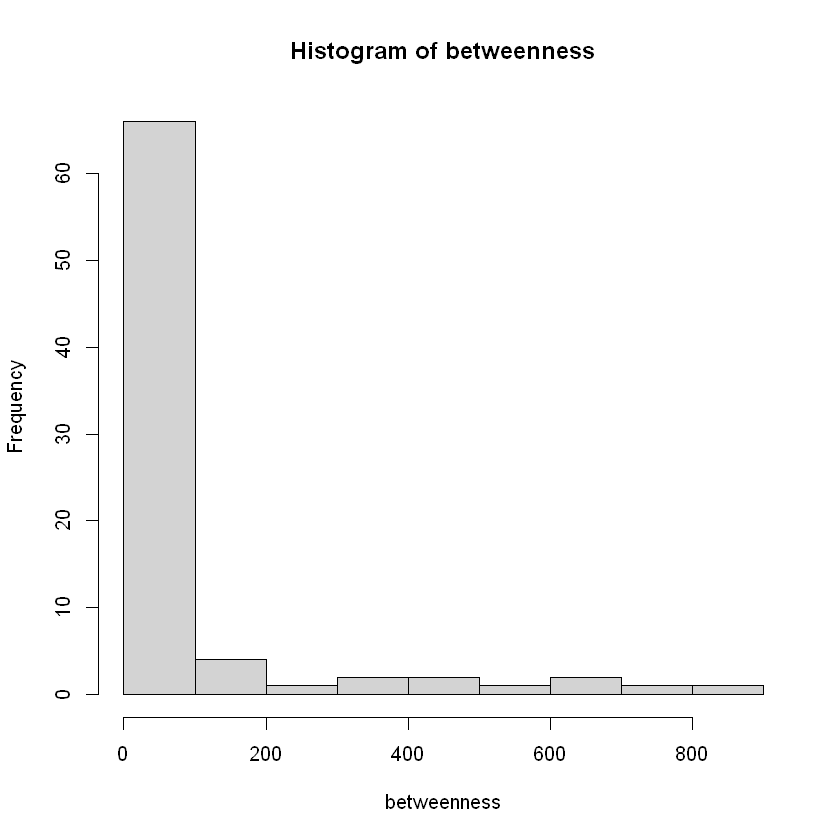

In [19]:
# Istogramma della Betweenness Centrality
hist(betweenness)

In [20]:
summary(betweenness)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   8.899  90.763  60.417 899.793 

![](imagesWorldMaps/Betweenness_Centrality.png)

Top 10 Nazioni rispetto alla Betweenness

In [21]:
centr_betw(g, directed = TRUE)$centralization

[1] 0.1329555

#### Conclusioni  

- Dall'istogramma si può notare che molti paesi hanno una Betweenness bassa
- Se interpretiamo la Betweenness centrality come la capacità di fare da "tramite" tra due paesi, dato che la transitività (e in particolare tau) è molto alta, non sembrerebbe esserci la necessità, infatti il valore di centralizzazione è molto vicino allo 0.

## EigenVector Centrality

In [22]:
eigen_centrality <- eigen_centrality(g)$vector

I Dati da noi ottenuti per la EigenVector Centrality sono i seguenti:

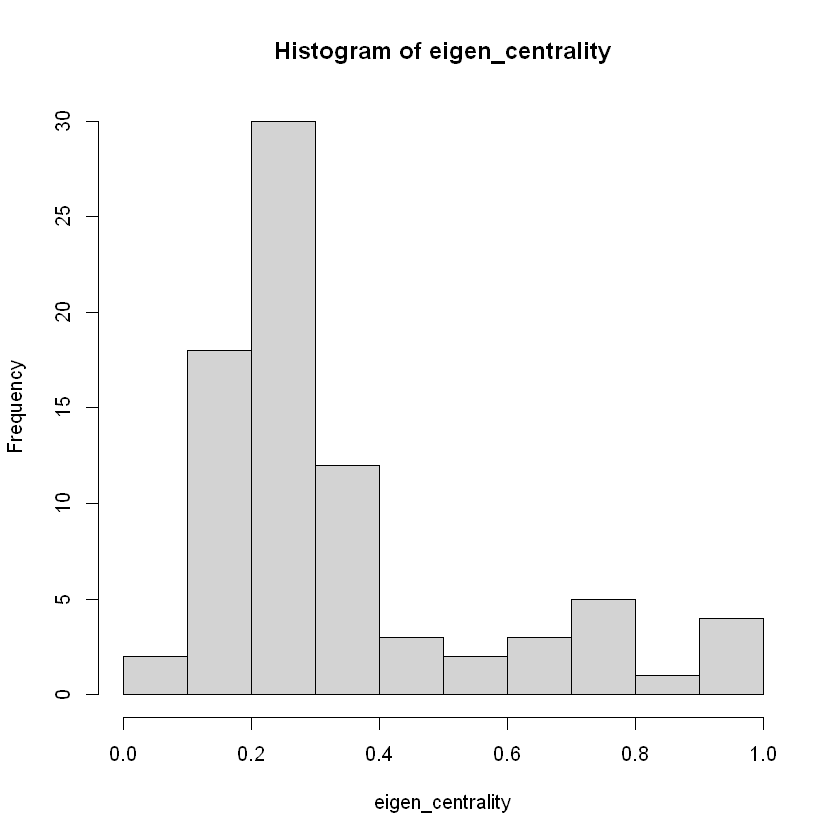

In [23]:
# Istrogramma dell'EigenVector Centrality
hist(eigen_centrality)

In [24]:
summary(eigen_centrality)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.08979 0.19907 0.28056 0.34384 0.36383 1.00000 

![](imagesWorldMaps/EigenVector_Centrality.png)

Top 10 Nazioni rispetto all'EigenVector Value

#### Conclusioni

- Anche in questo caso i Top 10 sono i Paesi più sviluppati, che abbiamo menzionato in precedenza (nell'Out Degree)

# Modelli

## Simple Random Graph Model (SRG)

Breve Introduzione al SRG

Adesso andiamo ad analizzare il SRG model, che rappresenta una base di partenza per tutti gli altri modelli

In [25]:
summary(model_SRG)

Call:
ergm(formula = net ~ edges, control = control.ergm(seed = 1, 
    checkpoint = "mod0_step_%03d.RData"))

Maximum Likelihood Results:

      Estimate Std. Error MCMC % z value Pr(>|z|)    
edges -1.67385    0.03449      0  -48.52   <1e-04 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

     Null Deviance: 8761  on 6320  degrees of freedom
 Residual Deviance: 5513  on 6319  degrees of freedom
 
AIC: 5515  BIC: 5522  (Smaller is better. MC Std. Err. = 0)

Simuliamo il SRG model e vediamo quali statistiche riesce a catturare e quali no, così da avere una base di partenza per i modelli che andremo a creare

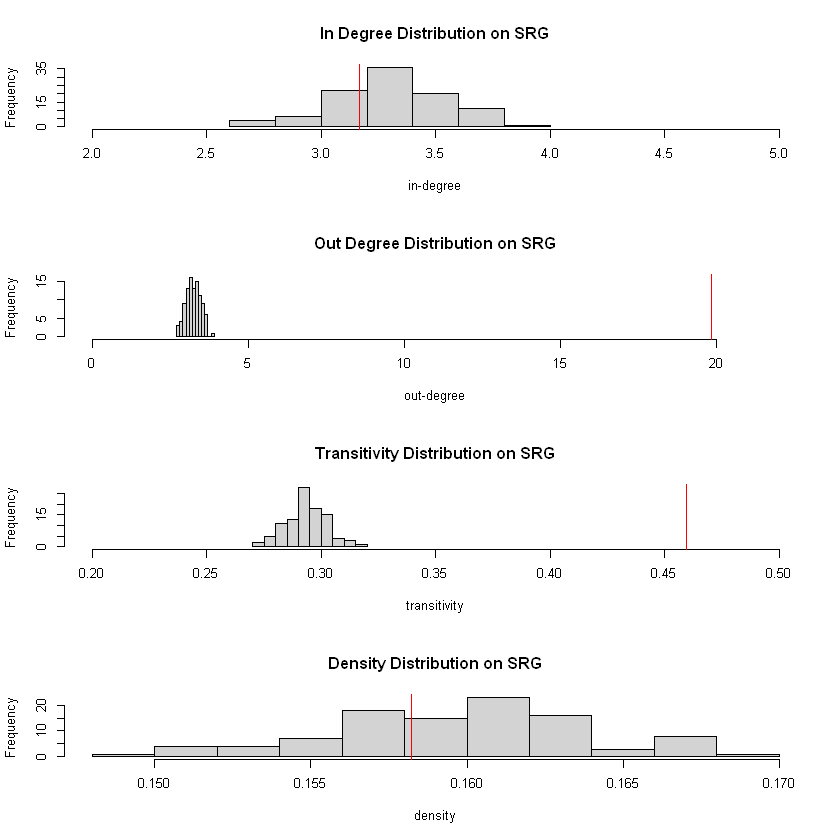

In [26]:
extractInformationsFromGraph <- function(xx){
	ig <- asIgraph(xx)
	tr <- transitivity(ig)
	ideg <- sd(degree(ig, mode = "in"))
	odeg <- sd(degree(ig, mode = "out"))
	dens <- edge_density(ig)
	return(c(tr, ideg, odeg, dens))
}

sim_SRG <- suppressMessages(simulate(model_SRG, nsim = 100, verbose = TRUE, seed = 1))

null.distr_SRG <- matrix(,100,4)
for(b in 1:100){
	null.distr_SRG[b,] <- extractInformationsFromGraph(sim_SRG[[b]])
}

par(mfrow = c(4,1))
hist(unlist(null.distr_SRG[,2]), xlab = "in-degree", xlim = c(2,5), main = "In Degree Distribution on SRG"); abline(v = sd(degree(g, mode = "in")), col = "red")
hist(unlist(null.distr_SRG[,3]), xlab = "out-degree", xlim=c(0, 22), main = "Out Degree Distribution on SRG"); abline(v = sd(degree(g, mode = "out")), col = "red")
hist(unlist(null.distr_SRG[,1]), xlab = "transitivity", xlim=c(0.2, 0.5), main = "Transitivity Distribution on SRG"); abline(v = transitivity(g), col = "red")
hist(unlist(null.distr_SRG[,4]), xlab = "density", main = "Density Distribution on SRG"); abline(v = edge_density(g), col = "red")

Il nostro attuale modello è in grado di catturare la densità (come potevamo aspettarci) e la In-Degree.

## Exponential Random Graph Models (ERGMs)

### Non-Homogeneus Simple Random Graph Model (NH-SRG)

Breve Introduzione al NH-SRG e differenze con SRG

Adesso andiamo ad analizzare i risultati ottenuti dal calcolo del NH-SRG model

In [ ]:
summary(model_NHSRG)

Dato che il summary del NH-SRG richiedeva molto spazio, abbiamo deciso di inserire degli screenshot.


![](images/model_NHSRG_p1.png)
![](images/model_NHSRG_p2.png)

Da come possiamo notare alcuni Sender Effect hanno valore Infinito, dunque siamo costretti a togliere dal modello il Sender Effect.

In [28]:
summary(model_NHSRG_onlyReceiver)

Call:
ergm(formula = net ~ edges + receiver, control = control.ergm(seed = 1, 
    checkpoint = "mod1_receiver_step_%03d.RData"))

Maximum Likelihood Results:

             Estimate Std. Error MCMC % z value Pr(>|z|)    
edges      -1.535e+00  2.946e-01      0  -5.211   <1e-04 ***
receiver2  -8.938e-02  4.230e-01      0  -0.211   0.8326    
receiver3   3.148e-01  3.984e-01      0   0.790   0.4295    
receiver4  -8.938e-02  4.230e-01      0  -0.211   0.8326    
receiver5  -2.863e-01  4.387e-01      0  -0.653   0.5140    
receiver6  -5.159e-01  4.607e-01      0  -1.120   0.2627    
receiver7  -8.938e-02  4.230e-01      0  -0.211   0.8326    
receiver8  -2.863e-01  4.387e-01      0  -0.653   0.5140    
receiver9  -1.845e-01  4.302e-01      0  -0.429   0.6681    
receiver10 -8.938e-02  4.230e-01      0  -0.211   0.8326    
receiver11 -5.159e-01  4.607e-01      0  -1.120   0.2627    
receiver12  2.414e-01  4.022e-01      0   0.600   0.5484    
receiver13 -6.479e-01  4.753e-01      0  -1.363

Da come si può notare i Receiver Effect hanno dei livelli di significatività molto bassi, quindi valutiamo la rimozione di essi.

In [29]:
table <- data.frame(
    Modelli = c("model_SRG", "model_NHSRG_onlyReceiver"),
    BIC = BIC(model_SRG, model_NHSRG_onlyReceiver)
)
createImageFromTable(table, "images/SRG_vs_NHSRG_BIC.png", 900, 220, 230)

![](images/SRG_vs_NHSRG_BIC.png)

Confrontando quindi questo modello con il modello SRG concludiamo che togliere il termine Receiver Effect è una buona scelta.

### P1 Model

Adesso andiamo ad analizzare i risultati ottenuti per il nostro P1 Model

In [30]:
summary(model_P1_onlyMutual)

Call:
ergm(formula = net ~ edges + mutual, control = control.ergm(seed = 1))

Monte Carlo Maximum Likelihood Results:

       Estimate Std. Error MCMC % z value Pr(>|z|)    
edges  -1.80765    0.04673      0 -38.684   <1e-04 ***
mutual  0.69042    0.12252      0   5.635   <1e-04 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

     Null Deviance: 8761  on 6320  degrees of freedom
 Residual Deviance: 5481  on 6318  degrees of freedom
 
AIC: 5485  BIC: 5499  (Smaller is better. MC Std. Err. = 1.073)

### Attributi Nodali

Adesso introduciamo gli effetti principali e di omofilia rispetto agli Attributi Nodali

In [31]:
summary(model_P1_onlyMutual_NodeAttr)

Call:
ergm(formula = net ~ edges + mutual + nodecov("gdp") + nodefactor("continent") + 
    nodefactor("partition") + absdiff("gdp") + nodematch("continent") + 
    nodematch("partition"), control = control.ergm(seed = 1))

Monte Carlo Maximum Likelihood Results:

                         Estimate Std. Error MCMC % z value Pr(>|z|)    
edges                   3.074e+00  3.389e-01      0   9.069  < 1e-04 ***
mutual                 -1.912e+00  1.795e-01      0 -10.655  < 1e-04 ***
nodecov.gdp             1.251e-05  4.386e-06      0   2.852 0.004342 ** 
nodefactor.continent.2 -2.665e-02  1.265e-01      0  -0.211 0.833080    
nodefactor.continent.3 -6.301e-01  1.314e-01      0  -4.795  < 1e-04 ***
nodefactor.continent.4  9.280e-01  1.654e-01      0   5.609  < 1e-04 ***
nodefactor.continent.5  7.066e-01  2.123e-01      0   3.328 0.000876 ***
nodefactor.continent.6 -2.808e-02  1.304e-01      0  -0.215 0.829440    
nodefactor.partition.2 -2.834e+00  1.500e-01      0 -18.890  < 1e-04 ***
nodef

Dal summary possiamo notare che l'effetto di Omofilia dell'attributo Partition non risulta essere significativo, quindi procediamo a togliere tale effetto dal nostro modello

In [32]:
summary(model_P1_onlyMutual_NodeAttr_noPartitionHomophily)

Call:
ergm(formula = net ~ edges + mutual + nodecov("gdp") + nodefactor("continent") + 
    nodefactor("partition") + absdiff("gdp") + nodematch("continent"), 
    control = control.ergm(seed = 1))

Monte Carlo Maximum Likelihood Results:

                         Estimate Std. Error MCMC % z value Pr(>|z|)    
edges                   3.116e+00  3.353e-01      0   9.294  < 1e-04 ***
mutual                 -1.902e+00  1.809e-01      0 -10.515  < 1e-04 ***
nodecov.gdp             1.184e-05  4.379e-06      0   2.703  0.00687 ** 
nodefactor.continent.2 -3.527e-02  1.278e-01      0  -0.276  0.78259    
nodefactor.continent.3 -6.300e-01  1.337e-01      0  -4.713  < 1e-04 ***
nodefactor.continent.4  9.170e-01  1.590e-01      0   5.769  < 1e-04 ***
nodefactor.continent.5  6.947e-01  2.180e-01      0   3.187  0.00144 ** 
nodefactor.continent.6 -2.337e-02  1.359e-01      0  -0.172  0.86351    
nodefactor.partition.2 -2.928e+00  1.355e-01      0 -21.615  < 1e-04 ***
nodefactor.partition.3 -4.109e

Adesso andiamo a comparare i modelli appena calcolati con il modello SRG per verificare quale tra di essi sia il migliore

In [33]:
table <- data.frame(
    Modelli = c("model_SRG", "model_P1_onlyMutual", "model_P1_onlyMutual_NodeAttr", "model_P1_onlyMutual_NodeAttr_noPartitionHomophily"),
    BIC = BIC(model_SRG, model_P1_onlyMutual, model_P1_onlyMutual_NodeAttr, model_P1_onlyMutual_NodeAttr_noPartitionHomophily)
)
createImageFromTable(table, "images/SRG_and_P1_Models_BIC.png", 1350, 350, 230)

![](images/SRG_and_P1_Models_BIC.png)

"model_P1_onlyMutual_NodeAttr" e "model_P1_onlyMutual_NodeAttr_noPartitionHomophily" sono i due modelli migliori e differiscono tra di loro di veramente pochi punti, ragion per cui per decidere il miglior modello P1 confronteremo l'abilità di questi modelli nel simulare le statistiche di rete e le statistiche nodali.

In [34]:
sim1 <- suppressMessages(simulate(model_P1_onlyMutual_NodeAttr, nsim = 100, verbose = TRUE, seed = 1))

null.distr1 <- matrix(,100,4)
for(b in 1:100){
	null.distr1[b,] <- extractInformationsFromGraph(sim1[[b]])
}

sim2 <- suppressMessages((simulate(model_P1_onlyMutual_NodeAttr_noPartitionHomophily, nsim = 100, verbose = TRUE, seed = 1)))

null.distr2 <- matrix(,100,4)
for(b in 1:100){
	null.distr2[b,] <- extractInformationsFromGraph(sim2[[b]])
}


In [35]:
png("images/model_P1_onlyMutual_NodeAttr_VS_model_P1_onlyMutual_NodeAttr_noPartitionHomophily__Part1.png", width = 1000, height = 1000, res = 150)
par(mfrow = c(4,1))
hist(unlist(null.distr1[,2]), xlab = "in-degree", xlim = c(2,12), main = "In Degree Distribution with Partition Homophily"); abline(v = sd(degree(g, mode = "in")), col = "red")
hist(unlist(null.distr2[,2]), xlab = "in-degree", xlim = c(2,12), main = "In Degree Distribution without Partition Homophily"); abline(v = sd(degree(g, mode = "in")), col = "red")
hist(unlist(null.distr1[,3]), xlab = "out-degree", xlim=c(5, 22), main = "Out Degree Distribution with Partition Homophily"); abline(v = sd(degree(g, mode = "out")), col = "red")
hist(unlist(null.distr2[,3]), xlab = "out-degree", xlim=c(5, 22), main = "Out Degree Distribution without Partition Homophily"); abline(v = sd(degree(g, mode = "out")), col = "red")
invisible(dev.off())

png("images/model_P1_onlyMutual_NodeAttr_VS_model_P1_onlyMutual_NodeAttr_noPartitionHomophily__Part2.png", width = 1000, height = 1000, res = 150)
par(mfrow = c(4,1))
hist(unlist(null.distr1[,1]), xlab = "transitivity", xlim=c(0.4, 0.5), main = "Transitivity Distribution with Partition Homophily"); abline(v = transitivity(g), col = "red")
hist(unlist(null.distr2[,1]), xlab = "transitivity", xlim=c(0.4, 0.5), main = "Transitivity Distribution without Partition Homophily"); abline(v = transitivity(g), col = "red")
hist(unlist(null.distr1[,4]), xlab = "density", main = "Density Distribution with Partition Homophily"); abline(v = edge_density(g), col = "red")
hist(unlist(null.distr2[,4]), xlab = "density", main = "Density Distribution without Partition Homophily"); abline(v = edge_density(g), col = "red")
invisible(dev.off())


![](images/model_P1_onlyMutual_NodeAttr_VS_model_P1_onlyMutual_NodeAttr_noPartitionHomophily__Part1.png)

![](images/model_P1_onlyMutual_NodeAttr_VS_model_P1_onlyMutual_NodeAttr_noPartitionHomophily__Part2.png)

Apparentemente dai metodi di valutazione AIC e BIC viene da pensare che questi ultimi due modelli siano migliori del modello SRG ma a quanto pare perdiamo la capacità di catturare la In-Degree della nostra Rete.

### Markov Graph Model

Poi abbiamo provato a generare modelli di Markov, ma sfortunatamente molti di essi hanno dato Degeneracy Problems.

L'unico modello di Markov che siamo riusciti a calcolare è stato il modello che utilizzava soltanto le 2 Star in Input.

In [36]:
summary(model_Markov_onlyIStar2)

Call:
ergm(formula = net ~ edges + mutual + nodecov("gdp") + nodefactor("continent") + 
    nodefactor("partition") + absdiff("gdp") + nodematch("continent") + 
    nodematch("partition") + istar(2), control = control.ergm(seed = 1, 
    checkpoint = "mod3_onlyIStar2/step_%03d.RData"))

Monte Carlo Maximum Likelihood Results:

                         Estimate Std. Error MCMC % z value Pr(>|z|)    
edges                   7.810e+00  5.413e-01      0  14.429  < 1e-04 ***
mutual                 -1.002e+00  1.923e-01      0  -5.212  < 1e-04 ***
nodecov.gdp             1.382e-05  5.058e-06      0   2.733  0.00628 ** 
nodefactor.continent.2  2.519e-01  1.684e-01      0   1.496  0.13461    
nodefactor.continent.3 -3.721e-01  1.718e-01      0  -2.166  0.03027 *  
nodefactor.continent.4  1.652e+00  2.226e-01      0   7.423  < 1e-04 ***
nodefactor.continent.5  1.079e+00  2.653e-01      0   4.067  < 1e-04 ***
nodefactor.continent.6  8.533e-02  1.771e-01      0   0.482  0.62992    
nodefactor.par

Dal summary possiamo notare che l'effetto di omofilia rispetto alla partizione non è significativa, quindi possiamo provare a ricalcolare il modello togliendo tale effetto e verificare se questo migliori oppure no

In [37]:
summary(model_Markov_onlyIStar2_noPartitionHomophily)

Call:
ergm(formula = net ~ edges + mutual + nodecov("gdp") + nodefactor("continent") + 
    nodefactor("partition") + absdiff("gdp") + nodematch("continent") + 
    istar(2), control = control.ergm(seed = 1))

Monte Carlo Maximum Likelihood Results:

                         Estimate Std. Error MCMC % z value Pr(>|z|)    
edges                   7.849e+00  5.324e-01      0  14.744  < 1e-04 ***
mutual                 -1.002e+00  1.959e-01      0  -5.113  < 1e-04 ***
nodecov.gdp             1.365e-05  5.215e-06      0   2.617  0.00888 ** 
nodefactor.continent.2  2.616e-01  1.669e-01      0   1.568  0.11699    
nodefactor.continent.3 -3.625e-01  1.716e-01      0  -2.112  0.03465 *  
nodefactor.continent.4  1.645e+00  2.208e-01      0   7.451  < 1e-04 ***
nodefactor.continent.5  1.073e+00  2.670e-01      0   4.019  < 1e-04 ***
nodefactor.continent.6  8.907e-02  1.746e-01      0   0.510  0.60988    
nodefactor.partition.2 -3.405e+00  1.396e-01      0 -24.391  < 1e-04 ***
nodefactor.partitio

Poi abbiamo provato ad utilizzare la variante delle Alternating K-Star per ridurre la probabilità che i modelli di Markov degenerasserò, sfortunatamente però alcuni modelli hanno comunque dato problemi di degenerazione.<br>
Siamo stati in grado di calcolare solo due modelli:

- Il primo modello tiene in considerazione le Alternating K-Star in Ingresso (model_Markov_onlyAlterantingInKStar)
- Il secondo modello tiene in considerazione le Alternating K-Star in Uscita (model_Markov_onlyAlternatingOutKStar)

In [38]:
summary(model_Markov_onlyAlternatingInKStar)

Call:
ergm(formula = net ~ edges + mutual + nodecov("gdp") + nodefactor("continent") + 
    nodefactor("partition") + absdiff("gdp") + nodematch("continent") + 
    nodematch("partition") + +gwidegree(decay = 1, fixed = TRUE), 
    control = control.ergm(seed = 1))

Monte Carlo Maximum Likelihood Results:

                         Estimate Std. Error MCMC % z value Pr(>|z|)    
edges                   2.353e+00  3.952e-01      0   5.955   <1e-04 ***
mutual                 -1.759e+00  1.827e-01      0  -9.629   <1e-04 ***
nodecov.gdp             1.222e-05  4.826e-06      0   2.532   0.0113 *  
nodefactor.continent.2  2.153e-01  1.604e-01      0   1.342   0.1797    
nodefactor.continent.3 -3.934e-01  1.668e-01      0  -2.358   0.0184 *  
nodefactor.continent.4  1.459e+00  2.107e-01      0   6.926   <1e-04 ***
nodefactor.continent.5  1.007e+00  2.577e-01      0   3.908   <1e-04 ***
nodefactor.continent.6  5.868e-02  1.744e-01      0   0.337   0.7365    
nodefactor.partition.2 -3.022e+00  

In [39]:
summary(model_Markov_onlyAlternatingOutKStar)

Call:
ergm(formula = net ~ edges + mutual + nodecov("gdp") + nodefactor("continent") + 
    nodefactor("partition") + absdiff("gdp") + nodematch("continent") + 
    nodematch("partition") + +gwodegree(decay = 1, fixed = TRUE), 
    control = control.ergm(seed = 1), verbose = 3)

Monte Carlo Maximum Likelihood Results:

                         Estimate Std. Error MCMC % z value Pr(>|z|)    
edges                   3.548e+00  2.707e-01      0  13.107  < 1e-04 ***
mutual                 -1.616e+00  1.798e-01      0  -8.985  < 1e-04 ***
nodecov.gdp             5.457e-06  2.979e-06      0   1.832 0.066966 .  
nodefactor.continent.2 -2.627e-01  7.186e-02      0  -3.655 0.000257 ***
nodefactor.continent.3 -7.824e-01  8.143e-02      0  -9.609  < 1e-04 ***
nodefactor.continent.4  5.782e-01  1.295e-01      0   4.463  < 1e-04 ***
nodefactor.continent.5  4.714e-01  1.453e-01      0   3.244 0.001178 ** 
nodefactor.continent.6 -1.768e-01  7.481e-02      0  -2.363 0.018131 *  
nodefactor.partition.2

Dai dati sopra possiamo notare come:

- Il primo modello risulta dare poca significatività all'effetto di omofilia della Partizione
- Il secondo modello risulta dare poca significatività all'effetto principale dell'attributo GDP e all'effetto di omofilia della Partizione

Possiamo provare a rimuovere tali effetti dai modelli e verificare se sussiste un miglioramento dei modelli oppure no

In [40]:
summary(model_Markov_onlyAlternatingInKStar_noPartitionHomophily)

Call:
ergm(formula = net ~ edges + mutual + nodecov("gdp") + nodefactor("continent") + 
    nodefactor("partition") + absdiff("gdp") + nodematch("continent") + 
    gwidegree(decay = 1, fixed = TRUE), control = control.ergm(seed = 1))

Monte Carlo Maximum Likelihood Results:

                         Estimate Std. Error MCMC % z value Pr(>|z|)    
edges                   2.399e+00  3.964e-01      0   6.052  < 1e-04 ***
mutual                 -1.756e+00  1.810e-01      0  -9.703  < 1e-04 ***
nodecov.gdp             1.209e-05  4.717e-06      0   2.564 0.010361 *  
nodefactor.continent.2  2.149e-01  1.627e-01      0   1.321 0.186506    
nodefactor.continent.3 -3.838e-01  1.685e-01      0  -2.278 0.022718 *  
nodefactor.continent.4  1.450e+00  2.147e-01      0   6.756  < 1e-04 ***
nodefactor.continent.5  9.971e-01  2.615e-01      0   3.813 0.000137 ***
nodefactor.continent.6  6.639e-02  1.783e-01      0   0.372 0.709680    
nodefactor.partition.2 -3.105e+00  1.347e-01      0 -23.049  < 1e-

In [41]:
summary(model_Markov_onlyAlternatingOutKStar_noPartitionHomophily_noGDPMain)

Call:
ergm(formula = net ~ edges + mutual + nodefactor("continent") + 
    nodefactor("partition") + absdiff("gdp") + nodematch("continent") + 
    +gwodegree(decay = 1, fixed = TRUE), control = control.ergm(seed = 1), 
    verbose = 3)

Monte Carlo Maximum Likelihood Results:

                         Estimate Std. Error MCMC % z value Pr(>|z|)    
edges                   3.723e+00  2.656e-01      0  14.018  < 1e-04 ***
mutual                 -1.582e+00  1.752e-01      0  -9.027  < 1e-04 ***
nodefactor.continent.2 -2.492e-01  7.642e-02      0  -3.261 0.001110 ** 
nodefactor.continent.3 -7.339e-01  8.017e-02      0  -9.155  < 1e-04 ***
nodefactor.continent.4  5.730e-01  1.313e-01      0   4.363  < 1e-04 ***
nodefactor.continent.5  5.377e-01  1.387e-01      0   3.878 0.000105 ***
nodefactor.continent.6 -1.568e-01  7.508e-02      0  -2.088 0.036785 *  
nodefactor.partition.2 -2.784e+00  1.254e-01      0 -22.191  < 1e-04 ***
nodefactor.partition.3 -3.457e+00  1.807e-01      0 -19.137  < 1

In [42]:
table <- data.frame(
	Modelli = c("model_Markov_onlyIStar2", "model_Markov_onlyIStar2_noPartitionHomophily", "model_Markov_onlyAlternatingOutKStar", "model_Markov_onlyAlternatingOutKStar_noPartitionHomophily_noGDPMain", "model_Markov_onlyAlternatingInKStar", "model_Markov_onlyAlternatingInKStar_noPartitionHomophily"),
	BIC = BIC(model_Markov_onlyIStar2, model_Markov_onlyIStar2_noPartitionHomophily, model_Markov_onlyAlternatingOutKStar, model_Markov_onlyAlternatingOutKStar_noPartitionHomophily_noGDPMain, model_Markov_onlyAlternatingInKStar, model_Markov_onlyAlternatingInKStar_noPartitionHomophily)
)
createImageFromTable(table, "images/markovModels_BIC.png", 1700, 470, 230)

![](images/markovModels_BIC.png)

A quanto pare i modelli migliori risultano essere 'model_Markov_onlyAlternatingOutKStar' e 'model_Markov_onlyAlternatingOutKStar_noPartitionHomophily_noGDPMain', adesso proviamo a simularli e verificare quale dei due modelli riesce a catturare meglio le statistiche di rete e le statistiche nodali.

In [43]:
sim3 <- suppressMessages(simulate(model_Markov_onlyAlternatingOutKStar, nsim = 100, verbose = TRUE, seed = 1))

null.distr3 <- matrix(,100,4)
for(b in 1:100){
	null.distr3[b,] <- extractInformationsFromGraph(sim3[[b]])
}

sim4 <- suppressMessages((simulate(model_Markov_onlyAlternatingOutKStar_noPartitionHomophily_noGDPMain, nsim = 100, verbose = TRUE, seed = 1)))

null.distr4 <- matrix(,100,4)
for(b in 1:100){
	null.distr4[b,] <- extractInformationsFromGraph(sim4[[b]])
}

In [44]:
png("images/model_Markov_onlyAlternatingOutKStar_VS_model_Markov_onlyAlternatingOutKStar_noPartitionHomophily_noGDPMain__Part1.png", width = 1000, height = 1000, res = 150)
par(mfrow = c(4,1))
hist(unlist(null.distr3[,2]), xlab = "in-degree", xlim = c(2,10), main = "In Degree Distribution with GDP Main and Partition Homophily"); abline(v = sd(degree(g, mode = "in")), col = "red")
hist(unlist(null.distr4[,2]), xlab = "in-degree", xlim = c(2,10), main = "In Degree Distribution without GDP Main and Partition Homophily"); abline(v = sd(degree(g, mode = "in")), col = "red")
hist(unlist(null.distr3[,3]), xlab = "out-degree", xlim = c(12, 20), main = "Out Degree Distribution with GDP Main and Partition Homophily"); abline(v = sd(degree(g, mode = "out")), col = "red")
hist(unlist(null.distr4[,3]), xlab = "out-degree", xlim = c(12, 20), main = "Out Degree Distribution without GDP Main and Partition Homophily"); abline(v = sd(degree(g, mode = "out")), col = "red")
invisible(dev.off())

png("images/model_Markov_onlyAlternatingOutKStar_VS_model_Markov_onlyAlternatingOutKStar_noPartitionHomophily_noGDPMain__Part2.png", width = 1000, height = 1000, res = 150)
par(mfrow = c(4,1))
hist(unlist(null.distr3[,1]), xlab = "transitivity", xlim = c(0.40, 0.48), main = "Transitivity Distribution with GDP Main and Partition Homophily"); abline(v = transitivity(g), col = "red")
hist(unlist(null.distr4[,1]), xlab = "transitivity", xlim = c(0.40, 0.48), main = "Transitivity Distribution without GDP Main and Partition Homophily"); abline(v = transitivity(g), col = "red")
hist(unlist(null.distr3[,4]), xlab = "density", xlim = c(0.13, 0.19), main = "Density Distribution with GDP Main and Partition Homophily"); abline(v = edge_density(g), col = "red")
hist(unlist(null.distr4[,4]), xlab = "density", xlim = c(0.13, 0.19), main = "Density Distribution without GDP Main and Partition Homophily"); abline(v = edge_density(g), col = "red")
invisible(dev.off())

![](images/model_Markov_onlyAlternatingOutKStar_VS_model_Markov_onlyAlternatingOutKStar_noPartitionHomophily_noGDPMain__Part1.png)

![](images/model_Markov_onlyAlternatingOutKStar_VS_model_Markov_onlyAlternatingOutKStar_noPartitionHomophily_noGDPMain__Part2.png)

I due modelli si comportano in modo molto simile. Il modello che scegliamo è il secondo (per via della minore complessità).

### Social Circuit Model

Infine abbiamo provato a generare dei modelli basati sulle condizioni del Social Circuit, ma sfortunatamente alcuni di essi hanno dato Degeneracy Problems.<br>
Siamo stati in grado di generare soltanto un modello basato sulle K-2 Paths.

In [45]:
summary(model_SocialCirtcuit_onlyK2Paths)

Call:
ergm(formula = net ~ edges + mutual + nodecov("gdp") + nodefactor("continent") + 
    nodefactor("partition") + absdiff("gdp") + nodematch("continent") + 
    nodematch("partition") + gwdsp(decay = 1, fixed = T), control = control.ergm(seed = 1), 
    verbose = 2)

Monte Carlo Maximum Likelihood Results:

                         Estimate Std. Error MCMC % z value Pr(>|z|)    
edges                   3.841e+00  3.459e-01      0  11.104   <1e-04 ***
mutual                 -1.302e-01  1.851e-01      0  -0.704   0.4816    
nodecov.gdp             3.804e-06  3.636e-06      0   1.046   0.2954    
nodefactor.continent.2  3.563e-02  1.217e-01      0   0.293   0.7696    
nodefactor.continent.3 -7.404e-01  1.274e-01      0  -5.812   <1e-04 ***
nodefactor.continent.4  1.028e+00  1.572e-01      0   6.540   <1e-04 ***
nodefactor.continent.5  7.795e-01  1.803e-01      0   4.323   <1e-04 ***
nodefactor.continent.6  2.247e-02  1.263e-01      0   0.178   0.8588    
nodefactor.partition.2 -2.547e

Dal summary si può notare che l'effetto di reciprocità e l'effetto principale del GDP non vengono considerati come significativi, quindi proviamo a calcolare un modello togliendo tali effetti.

In [46]:
summary(model_SocialCirtcuit_onlyK2Paths_NoMutualEffect_NoGDPMain)

Call:
ergm(formula = net ~ edges + nodefactor("continent") + nodefactor("partition") + 
    absdiff("gdp") + nodematch("continent") + nodematch("partition") + 
    gwdsp(decay = 1, fixed = T), control = control.ergm(seed = 1, 
    checkpoint = "mod5_gwdsp_2/step_%03d.RData"), verbose = 2)

Monte Carlo Maximum Likelihood Results:

                         Estimate Std. Error MCMC % z value Pr(>|z|)    
edges                   3.932e+00  3.055e-01      0  12.870   <1e-04 ***
nodefactor.continent.2  4.571e-02  1.167e-01      0   0.392   0.6952    
nodefactor.continent.3 -7.139e-01  1.235e-01      0  -5.780   <1e-04 ***
nodefactor.continent.4  1.028e+00  1.531e-01      0   6.716   <1e-04 ***
nodefactor.continent.5  7.981e-01  1.705e-01      0   4.680   <1e-04 ***
nodefactor.continent.6  3.193e-02  1.255e-01      0   0.254   0.7992    
nodefactor.partition.2 -2.567e+00  1.452e-01      0 -17.682   <1e-04 ***
nodefactor.partition.3 -4.086e+00  1.570e-01      0 -26.028   <1e-04 ***
absdiff.gdp

Adesso andiamo a confrontare i modelli appena calcolati con il precedente migliore modello (cioè 'model_Markov_onlyAlternatingOutKStar_noPartitionHomophily_noGDPMain')

In [47]:
table <- data.frame(
    Modelli = c("model_Markov_onlyAlternatingOutKStar_noPartitionHomophily_noGDPMain", "model_SocialCirtcuit_onlyK2Paths", "model_SocialCirtcuit_onlyK2Paths_NoMutualEffect_NoGDPMain"),
    BIC = BIC(model_Markov_onlyAlternatingOutKStar_noPartitionHomophily_noGDPMain, model_SocialCirtcuit_onlyK2Paths, model_SocialCirtcuit_onlyK2Paths_NoMutualEffect_NoGDPMain)
)
createImageFromTable(table, "images/socialCircuitModels_BIC.png", 1700, 300, 230)

![](images/socialCircuitModels_BIC.png)

I due nuovi modelli sono entrambi migliori del precedente e hanno punteggi molto simili, quindi andiamo a verificare quale dei due riesce a catturare meglio le statistiche di rete e le statistiche nodali

In [48]:
sim5 <- suppressMessages(simulate(model_SocialCirtcuit_onlyK2Paths, nsim = 100, verbose = TRUE, seed = 1))

null.distr5 <- matrix(,100,4)
for(b in 1:100){
	null.distr5[b,] <- extractInformationsFromGraph(sim5[[b]])
}

sim6 <- suppressMessages((simulate(model_SocialCirtcuit_onlyK2Paths_NoMutualEffect_NoGDPMain, nsim = 100, verbose = TRUE, seed = 1)))

null.distr6 <- matrix(,100,4)
for(b in 1:100){
	null.distr6[b,] <- extractInformationsFromGraph(sim6[[b]])
}

In [49]:
png("images/model_SocialCirtcuit_onlyK2Paths_VS_model_SocialCirtcuit_onlyK2Paths_NoMutualEffect_NoGDPMain__Part1.png", width = 1000, height = 1000, res = 150)
par(mfrow = c(4,1))
hist(unlist(null.distr5[,2]), xlab = "in-degree", xlim = c(2,10), main = "In Degree Distribution with Mutual Effect and GDP Main"); abline(v = sd(degree(g, mode = "in")), col = "red")
hist(unlist(null.distr6[,2]), xlab = "in-degree", xlim = c(0,20), main = "In Degree Distribution without Mutual Effect and GDP Main"); abline(v = sd(degree(g, mode = "in")), col = "red")
hist(unlist(null.distr5[,3]), xlab = "out-degree", xlim=c(12, 20), main = "Out Degree Distribution with Mutual Effect and GDP Main"); abline(v = sd(degree(g, mode = "out")), col = "red")
hist(unlist(null.distr6[,3]), xlab = "out-degree", xlim=c(0, 20), main = "Out Degree Distribution without Mutual Effect and GDP Main"); abline(v = sd(degree(g, mode = "out")), col = "red")
invisible(dev.off())

png("images/model_SocialCirtcuit_onlyK2Paths_VS_model_SocialCirtcuit_onlyK2Paths_NoMutualEffect_NoGDPMain__Part2.png", width = 1000, height = 1000, res = 150)
par(mfrow = c(4,1))
hist(unlist(null.distr5[,1]), xlab = "transitivity", main = "Transitivity Distribution with Mutual Effect and GDP Main"); abline(v = transitivity(g), col = "red")
hist(unlist(null.distr6[,1]), xlab = "transitivity", main = "Transitivity Distribution without Mutual Effect and GDP Main"); abline(v = transitivity(g), col = "red")
hist(unlist(null.distr5[,4]), xlab = "density", main = "Density Distribution with Mutual Effect and GDP Main"); abline(v = edge_density(g), col = "red")
hist(unlist(null.distr6[,4]), xlab = "density", main = "Density Distribution without Mutual Effect and GDP Main"); abline(v = edge_density(g), col = "red")
invisible(dev.off())

![](images/model_SocialCirtcuit_onlyK2Paths_VS_model_SocialCirtcuit_onlyK2Paths_NoMutualEffect_NoGDPMain__Part1.png)

![](images/model_SocialCirtcuit_onlyK2Paths_VS_model_SocialCirtcuit_onlyK2Paths_NoMutualEffect_NoGDPMain__Part2.png)

Anche se secondo il BIC il secondo modello dovrebbe essere leggermente meglio, prendendo in considerazione anche questi istogrammi ci rendiamo conto come il primo modello in realtà sia nettamente superiore rispetto al secondo.

## Finite Mixtures

### Stochastic Block Model

Adesso andiamo a calcolare lo Stochastic Block Model per la nostra rete

In [50]:
png("images/estimateSBM.png", width = 1000, height = 1000, res = 150)
sbm1 <- estimateSimpleSBM(as.matrix(Y), "bernoulli", dimLabels = 'nations',
												 estimOptions = list(verbosity = 1))
invisible(dev.off())

-> Estimation for 1 groups
-> Computation of eigen decomposition used for initalizations

-> Pass 1
-> Pass 2
-> Pass 3
-> Pass 4


![](images/estimateSBM.png)

A quanto pare il numero migliore di blocchi per la nostra rete è 6 (che corrisponde al numero di contienti della nostra rete).

In [51]:
sbm1

Fit of a Simple Stochastic Block Model -- bernoulli variant
Dimension = ( 80 ) - ( 6 ) blocks and no covariate(s).
* Useful fields 
  $nbNodes, $modelName, $dimLabels, $nbBlocks, $nbCovariates, $nbDyads
  $blockProp, $connectParam, $covarParam, $covarList, $covarEffect 
  $expectation, $indMemberships, $memberships 
* R6 and S3 methods 
  $rNetwork, $rMemberships, $rEdges, plot, print, coef 
* Additional fields
  $probMemberships, $loglik, $ICL, $storedModels, 
* Additional methods 
  predict, fitted, $setModel, $reorder 

In [52]:
m <- matrix(round(sbm1$connectParam$mean, 3), nrow = 6, 
  byrow = FALSE, 
  dimnames = list(c("B1", "B2", "B3", "B4", "B5", "B6"), c("B1", "B2", "B3", "B4", "B5", "B6")))

png("images/SBM_HeatMap.png", width = 1000, height = 1000, res = 150)

image(1:nrow(m), 1:ncol(m), t(apply(m, 2, rev)), axes = FALSE, main = "Matrix Heatmap of SBM", xlab = "", ylab = "", zlim = c(0, 1))

for(i in 1:nrow(m)) {
  for(j in 1:ncol(m)) {
    text(i, ncol(m)-j+1, labels = t(m)[i,j], cex = 1.2)
  }
}

mtext(rownames(m), side = 3, at = 1:nrow(m), line = 0.2)
mtext(rev(colnames(m)), side = 2, at = 1:ncol(m), line = 0.2)

invisible(dev.off())

![](images/SBM_HeatMap.png)

Analizzando l'Heatmap possiamo dedurre che:

- Il Blocco 1, composto da Paesi molto sviluppati (come Germania, Italia e Stati Uniti), invia collegamenti a tutti, specialmente a sé stesso, al Blocco 3 e al Blocco 5.
- Il Blocco 2, composto solamente da Paesi europei, invia collegamenti a tutti, anche se in minore quantità rispetto al Blocco 1, specialmente con sé stesso e il Blocco 5.
- Il Blocco 3, composto solamente da Paesi asiatici, invia collegamenti principalmente a sé stesso e in minore quantità anche con il Blocco 1 e il Blocco 6.
- Il Blocco 4, composto solamente da Paesi Americani, invia pochi collegamenti e principalmente a sé stesso.
- Il Blocco 5, composto solamente da Paesi europei, invia pochissimi collegamenti e principalmente a sé stesso, il Blocco 1 e il Blocco 6
- Il Blocco 6, composto dai Paesi rimanenti (principlamente poco sviluppati), invia quasi nessun collegamento.

![](imagesWorldMaps/Stochastic_Blockmodel.png)

Divisione degli 80 Paesi in base ai Blocchi del SBM

# Conclusioni


Alla fine possiamo trarre la conclusione che esiste una correlazione significativa tra lo scambio di metalli e la ricchezza di un paese. Questo fenomeno può essere attribuito al fatto che nei Paesi più sviluppati economicamente, il costo della manodopera è generalmente più elevato rispetto ai Paesi meno sviluppati. Inoltre, i metalli sono spesso utilizzati come materie prime per l'industria manifatturiera e l'edilizia, settori strettamente legati alla crescita economica. Di conseguenza, risulta più conveniente per i Paesi più ricchi importare i metalli piuttosto che estrarli autonomamente. Tuttavia, è importante sottolineare che ulteriori ricerche e analisi sono necessarie per approfondire la natura di questa relazione e comprendere appieno i fattori che la influenzano.